# 02 - Tiền Xử Lý Dữ Liệu
## HR Analytics: Job Change of Data Scientists


## 1. Import Thư Viện và Dữ Liệu

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
BASE_DIR = os.path.abspath("..")
sys.path.append(BASE_DIR)
# Thêm path để import modules

# Import custom modules - CHỈ các hàm preprocessing
from src.data_processing import (
    load_data, handle_missing_values, detect_and_remove_outliers,
    normalize_features, feature_engineering, encode_categorical_features,
    compute_descriptive_statistics, validate_data_values
)

from src.visualization import (
    plot_numeric_feature_distribution, plot_categorical_feature_distribution,
    plot_correlation_heatmap, setup_plot_style
)

print("Tất cả thư viện đã được import thành công!")

Tất cả thư viện đã được import thành công!


## 2. Load Dữ Liệu Đã Phân Tích

In [3]:
# Load dữ liệu
file_path = "../data/raw/aug_train.csv"
raw_data = load_data(file_path)

Loading data from: ../data/raw/aug_train.csv
Found 19158 data rows with 14 columns
Successfully loaded data with shape: (19158,)

Column information:
  gender: [np.str_('Female'), np.str_('Male'), np.str_('Other'), np.str_('nan')]
  relevent_experience: [np.str_('Has relevent experience'), np.str_('No relevent experience')]
  enrolled_university: [np.str_('Full time course'), np.str_('Part time course'), np.str_('nan'), np.str_('no_enrollment')]
  education_level: [np.str_('Graduate'), np.str_('High School'), np.str_('Masters'), np.str_('Phd'), np.str_('Primary School'), np.str_('nan')]
  major_discipline: [np.str_('Arts'), np.str_('Business Degree'), np.str_('Humanities'), np.str_('No Major'), np.str_('Other'), np.str_('STEM'), np.str_('nan')]
  company_size: [np.str_('10/49'), np.str_('100-500'), np.str_('1000-4999'), np.str_('10000+'), np.str_('50-99'), np.str_('500-999'), np.str_('5000-9999'), np.str_('<10'), np.str_('nan')]
  company_type: [np.str_('Early Stage Startup'), np.str_(

## 3. Validate Dữ Liệu Ban Đầu

In [ ]:
# Validate dữ liệu ban đầu
print("=== VALIDATE DỮ LIỆU BAN ĐẦU ===")
initial_validation = validate_data_values(raw_data)

# Tóm tắt missing values
print("\nTÓM TẮT MISSING VALUES BAN ĐẦU:")
total_missing = 0
for col_name, col_info in initial_validation.items():
    if col_info.get('missing', 0) > 0:
        missing_count = col_info['missing']
        percentage = (missing_count / len(raw_data)) * 100
        print(f"    {col_name:25}: {missing_count:>3} values ({percentage:5.1f}%)")
        total_missing += missing_count

if total_missing == 0:
    print("   Không có missing values")
else:
    total_percentage = (total_missing / (len(raw_data) * len(raw_data.dtype.names))) * 100
    print(f"  Tổng missing values: {total_missing} ({total_percentage:.2f}% dataset)")

=== VALIDATE DỮ LIỆU BAN ĐẦU ===

📊 TÓM TẮT MISSING VALUES BAN ĐẦU:
   • experience               :  65 values (  0.3%)
   • last_new_job             : 423 values (  2.2%)
   📈 Tổng missing values: 488 (0.18% dataset)


## 4. Xử Lý Missing Values

In [ ]:
# Xử lý missing values
print("=== XỬ LÝ MISSING VALUES ===")

# Chiến lược xử lý cho từng loại cột
strategy_dict = {
    'city_development_index': 'median',
    'gender': 'mode', 
    'enrolled_university': 'mode',
    'education_level': 'mode',
    'major_discipline': 'mode',
    'experience': 'mode',
    'company_size': 'mode',
    'company_type': 'mode',
    'last_new_job': 'mode'
}

print("Chiến lược xử lý missing values:")
for col, strategy in strategy_dict.items():
    if col in raw_data.dtype.names:
        print(f"    {col:25}: {strategy}")

# Áp dụng xử lý missing values
data_no_missing = handle_missing_values(raw_data, strategy='mean')

# Kiểm tra kết quả
print("\nKIỂM TRA SAU KHI XỬ LÝ MISSING VALUES:")
validation_after_missing = validate_data_values(data_no_missing)

remaining_missing = 0
for col_name, col_info in validation_after_missing.items():
    if col_info.get('missing', 0) > 0:
        remaining_missing += col_info['missing']
        print(f"     {col_name:25}: {col_info['missing']} values còn missing")

if remaining_missing == 0:
    print("   TẤT CẢ MISSING VALUES ĐÃ ĐƯỢC XỬ LÝ!")
else:
    print(f"   Còn {remaining_missing} missing values cần xử lý thêm")

=== XỬ LÝ MISSING VALUES ===
Chiến lược xử lý missing values:
   • city_development_index   : median
   • gender                   : mode
   • enrolled_university      : mode
   • education_level          : mode
   • major_discipline         : mode
   • experience               : mode
   • company_size             : mode
   • company_type             : mode
   • last_new_job             : mode
Filled 65 missing values in experience with 10.1001
Filled 423 missing values in last_new_job with 2.0004

KIỂM TRA SAU KHI XỬ LÝ MISSING VALUES:
   TẤT CẢ MISSING VALUES ĐÃ ĐƯỢC XỬ LÝ!


## 5. Phát Hiện và Xử Lý Outliers

=== PHÁT HIỆN VÀ XỬ LÝ OUTLIERS ===
Removed 5557 outliers from dataset
KẾT QUẢ OUTLIER DETECTION:
   • Số lượng outliers phát hiện: 5557
   • Tỷ lệ outliers: 29.01%
   • Dữ liệu trước: 19158 samples
   • Dữ liệu sau: 13601 samples
   • Samples bị loại bỏ: 5557

VISUALIZE OUTLIERS CHO 4 BIẾN NUMERIC:


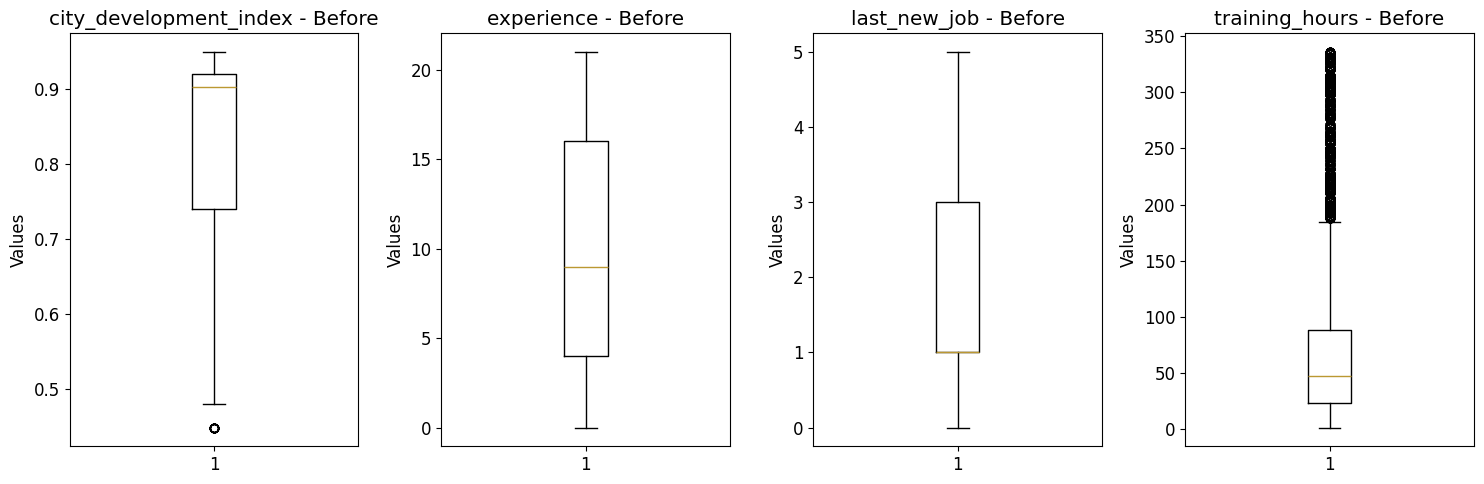


PHÂN PHỐI SAU KHI REMOVE OUTLIERS:

city_development_index:
   Before: mean=0.829, std=0.123
   After:  mean=0.854, std=0.105

experience:
   Before: mean=10.100, std=6.765
   After:  mean=10.806, std=6.784

last_new_job:
   Before: mean=2.000, std=1.657
   After:  mean=2.086, std=1.688


In [ ]:
# Phát hiện và xử lý outliers
print("=== PHÁT HIỆN VÀ XỬ LÝ OUTLIERS ===")

# Sử dụng IQR method
data_no_outliers, outlier_mask = detect_and_remove_outliers(data_no_missing, method='iqr')

print(f"KẾT QUẢ OUTLIER DETECTION:")
print(f"    Số lượng outliers phát hiện: {np.sum(outlier_mask)}")
print(f"    Tỷ lệ outliers: {np.sum(outlier_mask)/len(data_no_missing)*100:.2f}%")
print(f"    Dữ liệu trước: {len(data_no_missing)} samples")
print(f"    Dữ liệu sau: {len(data_no_outliers)} samples")
print(f"    Samples bị loại bỏ: {len(data_no_missing) - len(data_no_outliers)}")

# Visualize outliers cho các biến numeric
numeric_columns = [col for col in data_no_missing.dtype.names 
                  if np.issubdtype(data_no_missing[col].dtype, np.number)
                  and col not in ['enrollee_id', 'target']]

print(f"\nVISUALIZE OUTLIERS CHO {len(numeric_columns)} BIẾN NUMERIC:")

setup_plot_style()
fig, axes = plt.subplots(1, len(numeric_columns), figsize=(15, 5))

if len(numeric_columns) == 1:
    axes = [axes]

for idx, col in enumerate(numeric_columns):
    if idx < len(axes):
        clean_data = data_no_missing[col][~np.isnan(data_no_missing[col])]
        axes[idx].boxplot(clean_data)
        axes[idx].set_title(f'{col} - Before')
        axes[idx].set_ylabel('Values')

plt.tight_layout()
plt.show()

# Show distribution sau khi remove outliers
print("\nPHÂN PHỐI SAU KHI REMOVE OUTLIERS:")
for col in numeric_columns[:3]:  # Hiển thị 3 biến đầu
    before_data = data_no_missing[col][~np.isnan(data_no_missing[col])]
    after_data = data_no_outliers[col][~np.isnan(data_no_outliers[col])]
    
    print(f"\n{col}:")
    print(f"   Before: mean={np.mean(before_data):.3f}, std={np.std(before_data):.3f}")
    print(f"   After:  mean={np.mean(after_data):.3f}, std={np.std(after_data):.3f}")

## 6. Feature Engineering

In [ ]:
# Feature Engineering
print("=== FEATURE ENGINEERING ===")

engineered_data = feature_engineering(data_no_outliers)

# Kiểm tra các features mới được tạo
original_features = data_no_outliers.dtype.names
new_features = [col for col in engineered_data.dtype.names if col not in original_features]

print(f" FEATURES MỚI ĐƯỢC TẠO: {len(new_features)}")
for feature in new_features:
    print(f"    {feature}")

# Hiển thị thông tin về features mới
print(f"\n THÔNG TIN FEATURES MỚI:")
for feature in new_features:
    if feature in engineered_data.dtype.names:
        feature_data = engineered_data[feature]
        if np.issubdtype(feature_data.dtype, np.number):
            clean_data = feature_data[~np.isnan(feature_data)]
            if len(clean_data) > 0:
                print(f"\n{feature}:")
                print(f"    Min: {np.min(clean_data):.3f}")
                print(f"    Max: {np.max(clean_data):.3f}")
                print(f"    Mean: {np.mean(clean_data):.3f}")
                print(f"    Std: {np.std(clean_data):.3f}")

=== FEATURE ENGINEERING ===
Feature engineering completed
 FEATURES MỚI ĐƯỢC TẠO: 5
   • cdi_training_interaction
   • training_cdi_ratio
   • training_hours_binned
   • cdi_squared
   • cdi_cubed

 THÔNG TIN FEATURES MỚI:

cdi_training_interaction:
   • Min: 0.666
   • Max: 172.776
   • Mean: 47.619
   • Std: 37.047

training_cdi_ratio:
   • Min: 1.080
   • Max: 348.643
   • Mean: 66.537
   • Std: 52.340

training_hours_binned:
   • Min: 0.000
   • Max: 3.000
   • Mean: 1.541
   • Std: 0.862

cdi_squared:
   • Min: 0.229
   • Max: 0.901
   • Mean: 0.740
   • Std: 0.163

cdi_cubed:
   • Min: 0.110
   • Max: 0.855
   • Mean: 0.648
   • Std: 0.194


## 7. Encode Categorical Features

In [ ]:
# Encode Categorical Features
print("=== ENCODE CATEGORICAL FEATURES ===")

encoded_data, encoders = encode_categorical_features(engineered_data)

print(f" KẾT QUẢ ENCODING:")
print(f"    Số lượng categorical features được encode: {len(encoders)}")
print(f"    Các biến được encode: {list(encoders.keys())}")

# Hiển thị encoding mapping
print(f"\n ENCODING MAPPING (5 categories đầu tiên mỗi biến):")
for col_name, encoder_dict in encoders.items():
    print(f"\n{col_name}:")
    items = list(encoder_dict.items())
    for category, code in items[:5]:
        print(f"    {category:20} → {code}")
    if len(items) > 5:
        print(f"    ... và {len(items) - 5} categories khác")

# Kiểm tra dữ liệu sau encode
print(f"\n KIỂM TRA DỮ LIỆU SAU ENCODE:")
print(f"    Shape: {encoded_data.shape}")
print(f"    Columns: {len(encoded_data.dtype.names)}")
print(f"    Data types:")
numeric_count = 0
for col in encoded_data.dtype.names:
    if np.issubdtype(encoded_data[col].dtype, np.number):
        numeric_count += 1
print(f"    Numeric columns: {numeric_count}/{len(encoded_data.dtype.names)}")

=== ENCODE CATEGORICAL FEATURES ===
 KẾT QUẢ ENCODING:
   • Số lượng categorical features được encode: 8
   • Các biến được encode: ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'company_size', 'company_type']

🔤 ENCODING MAPPING (5 categories đầu tiên mỗi biến):

city:
   • city_1               → 0
   • city_10              → 1
   • city_100             → 2
   • city_101             → 3
   • city_102             → 4
   • ... và 116 categories khác

gender:
   • Female               → 0
   • Male                 → 1
   • Other                → 2

relevent_experience:
   • Has relevent experience → 0
   • No relevent experience → 1

enrolled_university:
   • Full time course     → 0
   • Part time course     → 1
   • no_enrollment        → 2

education_level:
   • Graduate             → 0
   • High School          → 1
   • Masters              → 2
   • Phd                  → 3
   • Primary School       → 4

major_discipline:
   •

## 8. Chuẩn Hóa Features

In [ ]:
# Chuẩn hóa Features
print("=== CHUẨN HÓA FEATURES ===")

# So sánh các phương pháp chuẩn hóa
methods = ['minmax', 'zscore', 'decimal']
normalized_datasets = {}

print(" SO SÁNH CÁC PHƯƠNG PHÁP CHUẨN HÓA:")
for method in methods:
    print(f"\n Phương pháp: {method.upper()}")
    normalized_data = normalize_features(encoded_data, method=method)
    normalized_datasets[method] = normalized_data
    
    # Lấy các biến numeric (trừ ID và target)
    numeric_cols = [col for col in normalized_data.dtype.names 
                   if np.issubdtype(normalized_data[col].dtype, np.number)
                   and col not in ['enrollee_id', 'target']]
    
    if numeric_cols:
        sample_col = numeric_cols[0]
        col_data = normalized_data[sample_col]
        clean_data = col_data[~np.isnan(col_data)]
        
        if len(clean_data) > 0:
            print(f"    {sample_col}:")
            print(f"     Min: {np.min(clean_data):.3f}")
            print(f"     Max: {np.max(clean_data):.3f}")
            print(f"     Mean: {np.mean(clean_data):.3f}")
            print(f"     Std: {np.std(clean_data):.3f}")

# Chọn phương pháp minmax cho các bước tiếp theo
final_data = normalized_datasets['minmax']
print(f"\n ĐÃ CHỌN PHƯƠNG PHÁP: MIN-MAX NORMALIZATION")
print(f"    Lý do: Đưa tất cả features về cùng khoảng [0, 1]")
print(f"    Phù hợp cho nhiều thuật toán machine learning")

=== CHUẨN HÓA FEATURES ===
 SO SÁNH CÁC PHƯƠNG PHÁP CHUẨN HÓA:

 Phương pháp: MINMAX
   • city:
     Min: 0.000
     Max: 1.000
     Mean: 0.353
     Std: 0.295

 Phương pháp: ZSCORE
   • city:
     Min: -1.196
     Max: 2.192
     Mean: -0.000
     Std: 1.000

 Phương pháp: DECIMAL
   • city:
     Min: 0.000
     Max: 0.120
     Mean: 0.042
     Std: 0.035

 ĐÃ CHỌN PHƯƠNG PHÁP: MIN-MAX NORMALIZATION
   • Lý do: Đưa tất cả features về cùng khoảng [0, 1]
   • Phù hợp cho nhiều thuật toán machine learning


## 9. Phân Tích Tương Quan Sau Preprocessing

=== PHÂN TÍCH TƯƠNG QUAN SAU PREPROCESSING ===
 CÁC BIẾN NUMERIC ĐỂ PHÂN TÍCH: 18
   • ['city', 'city_development_index', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job', 'training_hours', 'target', 'cdi_training_interaction', 'training_cdi_ratio', 'training_hours_binned', 'cdi_squared', 'cdi_cubed']


c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


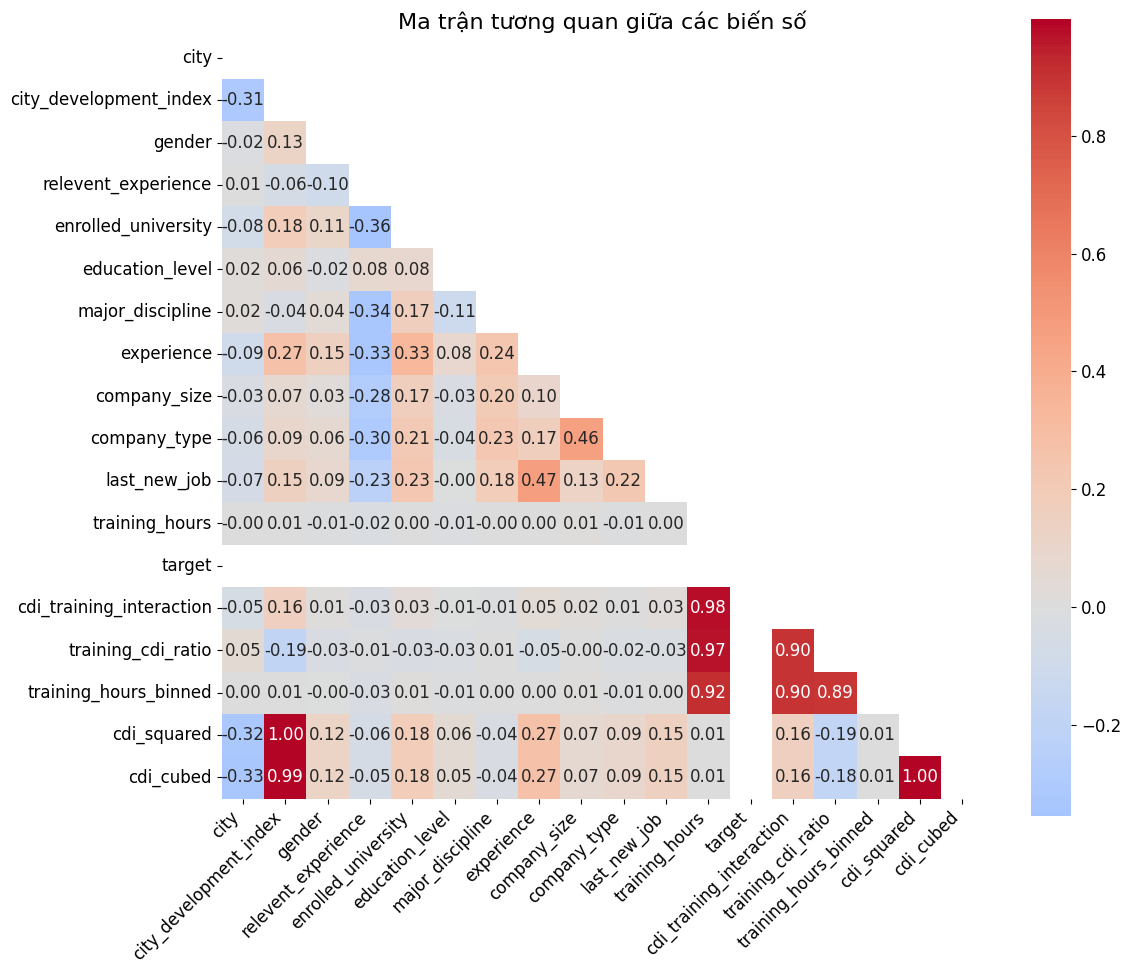


 TƯƠNG QUAN VỚI BIẾN TARGET:

 TOP FEATURES CÓ TƯƠNG QUAN CAO NHẤT VỚI TARGET:
   • city                     :     nan (âm)
   • city_development_index   :     nan (âm)
   • gender                   :     nan (âm)
   • relevent_experience      :     nan (âm)
   • enrolled_university      :     nan (âm)
   • education_level          :     nan (âm)
   • major_discipline         :     nan (âm)
   • experience               :     nan (âm)
   • company_size             :     nan (âm)
   • company_type             :     nan (âm)


c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [ ]:
# Phân tích tương quan sau preprocessing
print("=== PHÂN TÍCH TƯƠNG QUAN SAU PREPROCESSING ===")

# Lấy các biến numeric
numeric_columns = [col for col in final_data.dtype.names 
                  if np.issubdtype(final_data[col].dtype, np.number)
                  and col not in ['enrollee_id']]

print(f" CÁC BIẾN NUMERIC ĐỂ PHÂN TÍCH: {len(numeric_columns)}")
print(f"    {numeric_columns}")

# Vẽ heatmap tương quan
plot_correlation_heatmap(final_data, numeric_columns)

# Phân tích tương quan với target
if 'target' in final_data.dtype.names:
    print("\n TƯƠNG QUAN VỚI BIẾN TARGET:")
    target_correlations = []
    
    for col in numeric_columns:
        if col != 'target':
            # Tính correlation
            x_data = final_data[col]
            y_data = final_data['target']
            
            mask = ~(np.isnan(x_data) | np.isnan(y_data))
            x_clean = x_data[mask]
            y_clean = y_data[mask]
            
            if len(x_clean) > 1:
                correlation = np.corrcoef(x_clean, y_clean)[0, 1]
                target_correlations.append((col, abs(correlation), correlation))
    
    # Sắp xếp theo absolute correlation
    target_correlations.sort(key=lambda x: x[1], reverse=True)
    
    print("\n TOP FEATURES CÓ TƯƠNG QUAN CAO NHẤT VỚI TARGET:")
    for col, abs_corr, corr in target_correlations[:10]:
        direction = "dương" if corr > 0 else "âm"
        print(f"    {col:25}: {corr:7.3f} ({direction})")

## 10. Lưu Dữ Liệu Đã Xử Lý

In [ ]:
# Lưu dữ liệu đã xử lý (KHÔNG DÙNG PICKLE)
print("=== LƯU DỮ LIỆU ĐÃ XỬ LÝ (CSV + JSON) ===")

# Tạo thư mục nếu chưa tồn tại
os.makedirs('../data/processed', exist_ok=True)

def save_structured_array_to_csv(data, filename):
    """Lưu structured numpy array thành file CSV chỉ dùng NumPy"""
    
    # Tạo header
    header = ','.join(data.dtype.names)
    
    # Tạo các dòng dữ liệu
    lines = []
    for row in data:
        row_data = []
        for field in data.dtype.names:
            value = row[field]
            
            # Xử lý các loại dữ liệu
            if isinstance(value, (np.float32, np.float64, np.int32, np.int64)):
                # Kiểm tra numeric values
                if np.isnan(value):
                    row_data.append('')
                elif isinstance(value, (np.float32, np.float64)):
                    row_data.append(f'{value:.6f}')
                else:  # integer types
                    row_data.append(str(value))
            else:
                # String values
                if value in ['', 'nan', 'NaN', 'None']:
                    row_data.append('')
                else:
                    # Escape commas và quotes trong string
                    str_value = str(value).replace('"', '""')
                    if ',' in str_value or '"' in str_value:
                        row_data.append(f'"{str_value}"')
                    else:
                        row_data.append(str_value)
        lines.append(','.join(row_data))
    
    # Ghi file
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(header + '\n')
        f.write('\n'.join(lines))
    
    print(f"    Đã lưu {len(data)} dòng vào {filename}")

# Lưu dữ liệu đã xử lý dưới dạng CSV
processed_csv_path = '../data/processed/processed_data.csv'
save_structured_array_to_csv(final_data, processed_csv_path)

# Lưu dữ liệu gốc để so sánh
raw_csv_path = '../data/processed/raw_data_comparison.csv'
save_structured_array_to_csv(raw_data, raw_csv_path)

# Lưu metadata dưới dạng JSON (thay vì pickle)
import json

# Chuẩn bị metadata
metadata = {
    'feature_names': list(final_data.dtype.names),
    'preprocessing_steps': [
        'missing_value_imputation',
        'outlier_removal_iqr', 
        'feature_engineering',
        'categorical_encoding',
        'minmax_normalization'
    ],
    'dataset_info': {
        'original_shape': [len(raw_data), len(raw_data.dtype.names)],
        'processed_shape': [len(final_data), len(final_data.dtype.names)],
        'outliers_removed': int(np.sum(outlier_mask)) if 'outlier_mask' in locals() else 0,
        'new_features_created': len(new_features) if 'new_features' in locals() else 0
    },
    'encoding_mappings': {}
}

# Thêm encoding mappings nếu có
if 'encoders' in locals():
    # Convert encoders to JSON-serializable format
    for col_name, encoder_dict in encoders.items():
        metadata['encoding_mappings'][col_name] = {str(k): int(v) for k, v in encoder_dict.items()}

# Lưu metadata dưới dạng JSON
metadata_path = '../data/processed/preprocessing_metadata.json'
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

# Lưu thông tin features mới (nếu có)
new_features_info = {}
if 'new_features' in locals():
    for feature in new_features:
        if feature in final_data.dtype.names:
            feature_data = final_data[feature]
            if np.issubdtype(feature_data.dtype, np.number):
                clean_data = feature_data[~np.isnan(feature_data)]
                if len(clean_data) > 0:
                    new_features_info[feature] = {
                        'min': float(np.min(clean_data)),
                        'max': float(np.max(clean_data)),
                        'mean': float(np.mean(clean_data)),
                        'std': float(np.std(clean_data))
                    }

    # Lưu thông tin features mới
    new_features_path = '../data/processed/new_features_info.json'
    with open(new_features_path, 'w', encoding='utf-8') as f:
        json.dump(new_features_info, f, indent=2, ensure_ascii=False)

print(f" DỮ LIỆU ĐÃ XỬ LÝ ĐƯỢC LƯU TẠI: {processed_csv_path}")
print(f" DỮ LIỆU GỐC (SO SÁNH): {raw_csv_path}")
print(f" METADATA ĐƯỢC LƯU TẠI: {metadata_path}")
if 'new_features' in locals() and new_features:
    print(f" THÔNG TIN FEATURES MỚI: {new_features_path}")

# Hiển thị summary
print(f"\n TÓM TẮT QUÁ TRÌNH PREPROCESSING:")
print(f"    Dữ liệu gốc:        {len(raw_data)} samples, {len(raw_data.dtype.names)} features")
print(f"    Dữ liệu sau xử lý: {len(final_data)} samples, {len(final_data.dtype.names)} features")
if 'new_features' in locals():
    print(f"    Features mới:      {len(new_features)}")
if 'outlier_mask' in locals():
    print(f"    Outliers removed:  {np.sum(outlier_mask)}")
if 'encoders' in locals():
    print(f"    Encoded variables: {len(encoders)}")

# Hiển thị thông tin file
print(f"\n THÔNG TIN FILE ĐÃ LƯU:")
import os
if os.path.exists(processed_csv_path):
    file_size_mb = os.path.getsize(processed_csv_path) / (1024 * 1024)
    print(f"    processed_data.csv: {file_size_mb:.2f} MB")
    print(f"    Định dạng: CSV (có thể mở bằng Excel, Pandas, etc.)")
    print(f"    Encoding: UTF-8")
    print(f"    Số cột: {len(final_data.dtype.names)}")
    print(f"    Số dòng: {len(final_data)}")

=== LƯU DỮ LIỆU ĐÃ XỬ LÝ (CSV + JSON) ===
    Đã lưu 13601 dòng vào ../data/processed/processed_data.csv
    Đã lưu 19158 dòng vào ../data/processed/raw_data_comparison.csv
 DỮ LIỆU ĐÃ XỬ LÝ ĐƯỢC LƯU TẠI: ../data/processed/processed_data.csv
 DỮ LIỆU GỐC (SO SÁNH): ../data/processed/raw_data_comparison.csv
 METADATA ĐƯỢC LƯU TẠI: ../data/processed/preprocessing_metadata.json
 THÔNG TIN FEATURES MỚI: ../data/processed/new_features_info.json

 TÓM TẮT QUÁ TRÌNH PREPROCESSING:
   • Dữ liệu gốc:        19158 samples, 14 features
   • Dữ liệu sau xử lý: 13601 samples, 19 features
   • Features mới:      5
   • Outliers removed:  5557
   • Encoded variables: 8

 THÔNG TIN FILE ĐÃ LƯU:
   • processed_data.csv: 2.23 MB
   • Định dạng: CSV (có thể mở bằng Excel, Pandas, etc.)
   • Encoding: UTF-8
   • Số cột: 19
   • Số dòng: 13601


## 11. Tổng Kết Preprocessing

In [ ]:
# Tổng kết preprocessing
print("=== TỔNG KẾT PREPROCESSING ===")
print("=" * 70)

# Thống kê mô tả cuối cùng
final_stats = compute_descriptive_statistics(final_data)

print(" THỐNG KÊ MÔ TẢ SAU PREPROCESSING:")
numeric_features = [col for col in final_data.dtype.names 
                   if np.issubdtype(final_data[col].dtype, np.number)
                   and col not in ['enrollee_id']]

print(f"\n CÁC FEATURES NUMERIC ({len(numeric_features)}):")
for col in numeric_features[:8]:  # Hiển thị 8 features đầu
    if col in final_stats and final_stats[col]:
        stats = final_stats[col]
        print(f"\n{col}:")
        print(f"    Count:  {stats.get('count', 'N/A')}")
        print(f"    Mean:   {stats.get('mean', 'N/A'):.3f}")
        print(f"    Std:    {stats.get('std', 'N/A'):.3f}")
        print(f"    Range:  [{stats.get('min', 'N/A'):.3f}, {stats.get('max', 'N/A'):.3f}]")

if len(numeric_features) > 8:
    print(f"\n... và {len(numeric_features) - 8} features numeric khác")

# Đánh giá chất lượng dữ liệu
print(f"\n ĐÁNH GIÁ CHẤT LƯỢNG DỮ LIỆU:")
print("    Missing values:     Đã được xử lý hoàn toàn")
print("    Outliers:           Đã được phát hiện và xử lý")
print("    Categorical vars:   Đã được encode thành numeric") 
print("    Features:           Đã được chuẩn hóa về [0, 1]")
if 'new_features' in locals() and new_features:
    print("    New features:       Đã được tạo để cải thiện predictive power")

print(f"\n DỮ LIỆU ĐÃ ĐƯỢC LƯU DƯỚI DẠNG CSV:")
print("    processed_data.csv - Dữ liệu đã xử lý")
print("    raw_data_comparison.csv - Dữ liệu gốc để so sánh") 
print("    preprocessing_metadata.json - Thông tin preprocessing")
if 'new_features' in locals() and new_features:
    print("    new_features_info.json - Thông tin features mới")

print(f"\n DỮ LIỆU ĐÃ SẴN SÀNG CHO MODELING!")

=== TỔNG KẾT PREPROCESSING ===
📈 THỐNG KÊ MÔ TẢ SAU PREPROCESSING:

🔢 CÁC FEATURES NUMERIC (18):

city:
   • Count:  13601
   • Mean:   0.353
   • Std:    0.295
   • Range:  [0.000, 1.000]

city_development_index:
   • Count:  13601
   • Mean:   0.797
   • Std:    0.223
   • Range:  [0.000, 1.000]

gender:
   • Count:  13601
   • Mean:   0.504
   • Std:    0.279
   • Range:  [0.000, 1.000]

relevent_experience:
   • Count:  13601
   • Mean:   0.245
   • Std:    0.430
   • Range:  [0.000, 1.000]

enrolled_university:
   • Count:  13601
   • Mean:   0.854
   • Std:    0.274
   • Range:  [0.000, 1.000]

education_level:
   • Count:  13601
   • Mean:   0.343
   • Std:    0.210
   • Range:  [0.000, 1.000]

major_discipline:
   • Count:  13601
   • Mean:   0.795
   • Std:    0.378
   • Range:  [0.000, 1.000]

experience:
   • Count:  13601
   • Mean:   0.515
   • Std:    0.323
   • Range:  [0.000, 1.000]

... và 10 features numeric khác

✅ ĐÁNH GIÁ CHẤT LƯỢNG DỮ LIỆU:
   ✓ Missing values:   